# Face scoring

This notebook generates faces using Stable Diffusion implementation from diffusers.

The generation process depends on a seed that makes the results deterministic.

For generated images we then:
- run a method that runs MTCNN from `facenet_pytorch` to extract faces
- use FaceNet model to extract features that are used for comparing faces

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1

import glob
import matplotlib.pyplot as plt
import skimage.io
import torch
from torch import nn
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    EulerDiscreteScheduler,
)

from IPython import display
import ipywidgets
import ipyplot
import os
import numpy as np

import face_scoring
import diffusers

## Put your huggingface token in auth_token.txt

In [3]:
auth_token = open("auth_token.txt").read().strip()

In [4]:
%matplotlib inline

In [5]:
plt.style.use("dark_background")

In [6]:
def make_viewable_image_tensor(img_tensor):
    missing_img_nd = (img_tensor - img_tensor.min()) / (
        img_tensor.max() - img_tensor.min()
    )
    return missing_img_nd.cpu().numpy().transpose([1, 2, 0])

In [7]:
#old_sd_model_name = "CompVis/stable-diffusion-v1-4"
old_sd_model_name = "runwayml/stable-diffusion-v1-5"
sd_model_name = "stabilityai/stable-diffusion-2"
model_id = sd_model_name 
# pipe = StableDiffusionPipeline.from_pretrained(sd_model_name, revision="fp16", torch_dtype=torch.float16, use_auth_token=auth_token)

In [8]:
sd_ver = os.path.split(model_id)[1].replace("stable-diffusion-", "")

In [9]:
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

## Prompts

I put here some suggested prompts to generate diverse images.

The `{}` placeholder can be customized to generate images using selected people

In [10]:
all_prompts = """
Professional portrait of {} as President of United States, looking away, serious eyes, 50mm portrait, photography, hard rim lighting photography –ar 2:3 –beta –upbeta
{} in Cyberpunk, portrait, RTX, high resolution
{} in minecraft, raytraced 4k
Mongolian {} portrait, highly detailed, 4 k, hdr, smooth, sharp focus, high resolution, award – winning photo
Film still of {} in 80s sitcom, upbeat
Film still of {} in Game of Thrones
{} painting by Leonardo da Vinci
{} as religious figure, national geographic, portrait, photo, photography –s 625 –q 2 –iw 3
Still shot of {} on Joe Rogan podcast,  hard rim lighting photography–beta –ar 2:3 –beta –upbeta –beta –upbeta –beta –upbeta
{} bust, greek sculpture, Unreal Engine 4k
{} in the style of Norman Rockwell
Fauvist {} painting
{} surrounded by foliage, dreamy autochrome pinhole photography
ultrarealistic, {} portrait, cinematic lighting, award winning photo, no color, 80mm lense –beta –upbeta –upbeta
full length photo of {} as a warrior, highly detailed, 4 k, hdr, smooth, sharp focus, high resolution, award – winning photo
{} as GTA V cover character
""".strip().split(
    "\n"
)

In [11]:
small_prompts = """
{} psychedelic trance album cover
{} in Cyberpunk portrait, PS2, high resolution
Mongolian {} portrait, highly detailed, 4 k, hdr, smooth, sharp focus, high resolution, award – winning photo
{} renaissance painting by Leonardo da Vinci
{} as religious figure, national geographic, portrait, photo, photography –s 625 –q 2 –iw 3
{} bust, greek sculpture, Unreal Engine 4k
{} in the style of Norman Rockwell
Fauvist {} painting
{} as GTA V cover character
""".strip().split(
    "\n"
)

In [12]:
prompts = all_prompts

In [13]:
def save_images(named_imgs, save_dir):
    for name, imgs in named_imgs.items():
        for i, img in enumerate(imgs):
            fname = name + "_" + str(i) + ".jpg"
            img.save(open(os.path.join(save_dir, fname), "wb"))


def get_imgs(
    prompts,
    X,
    height=512,
    width=512,
    num_inference_steps=100,
    display_imgs=True,
    num_images_per_prompt=3,
    **kwargs
):
    rgenerator = torch.Generator("cuda").manual_seed(2137)
    for raw_prompt in prompts:
        prompt = raw_prompt.format(X)
        with torch.cuda.amp.autocast():
            imgs = pipe(
                prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                generator=rgenerator,
                num_images_per_prompt=num_images_per_prompt,
                **kwargs
            ).images
        if display_imgs:
            print(prompt)
            ipyplot.plot_images(imgs, img_width=256)
        yield prompt, imgs

## OFF WE GO

These prompts are bound to generate weird images.

Generating images from a single prompt to show them in stored notebook...

In [17]:
sd_ver

'2'

  0%|          | 0/100 [00:00<?, ?it/s]

Escher style pencil drawing of octopus on a bicycle



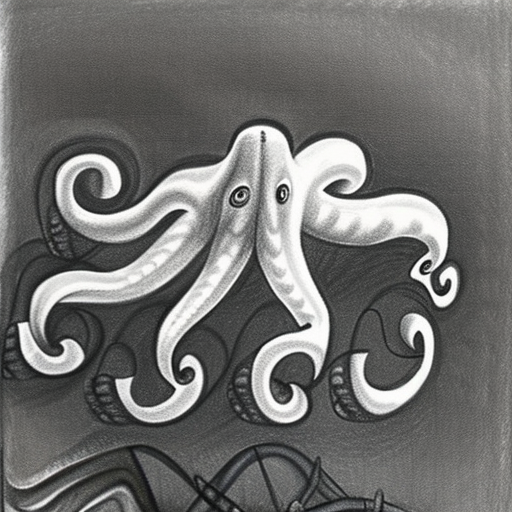
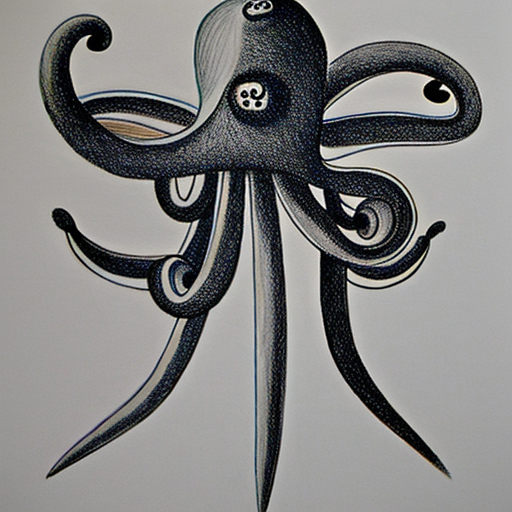
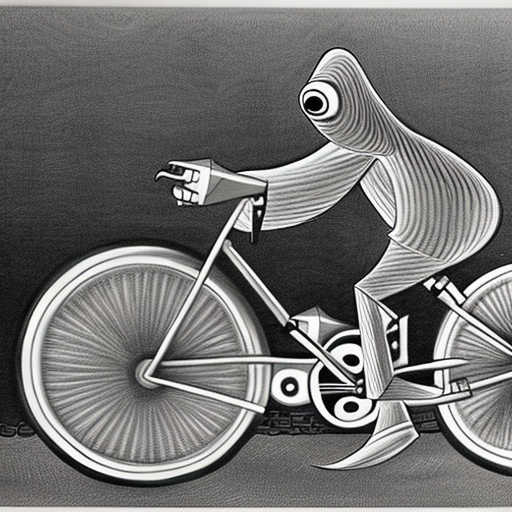


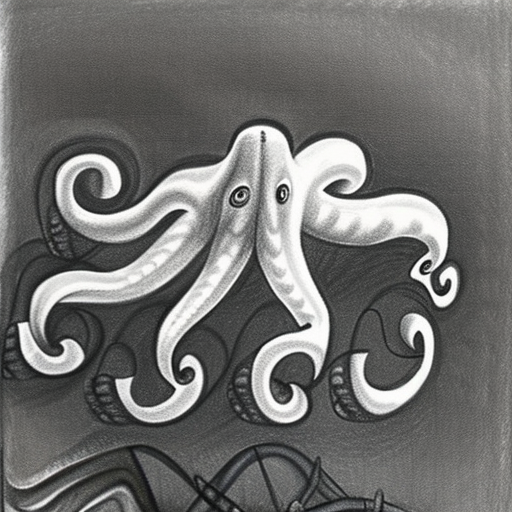
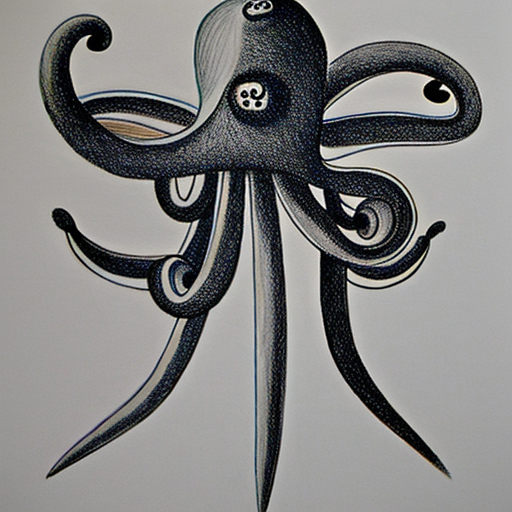
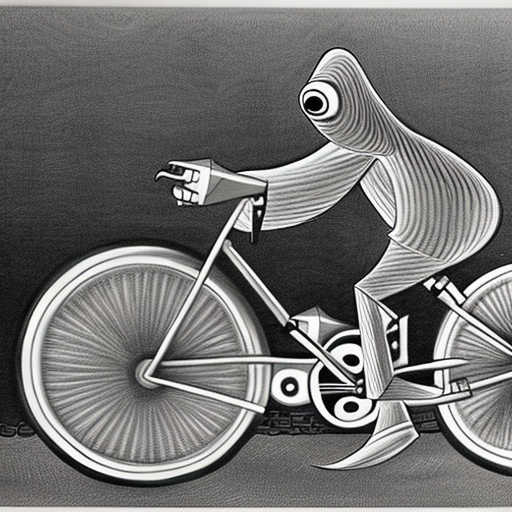

In [16]:
weird_queries = [
    "Escher style pencil drawing of octopus on a bicycle{}",
    "Alex Jones portrait, psychedelic trance album cover{}",
    "Escher style pencil drawing of octopus bicycle{}",
    "Leonardo da Vinci pencil drawing of octopus riding a bicycle{}",
    "Xenomorph birthday party{}",
    "Jewish octopus playing with dreidel{}",
    "Octopus circle limit by Escher{}"
]
weird_imgs = dict(get_imgs([weird_queries[0]], "", num_inference_steps=100, guidance_scale=12.5))

In [ ]:
weird_imgs = dict(get_imgs(weird_queries, "", num_inference_steps=100, guidance_scale=12.5))

In [ ]:
!mkdir weird_images$sd_ver
!mkdir still_lifes$sd_ver

In [ ]:
save_images(weird_imgs, "weird_images" + sd_ver)

In [ ]:
octo_prompts = ["Octopus circle limit, pencil drawing by Escher{}", "Octopus circle limit by Escher{}", "Octopus floor tiling by Escher{}"]
octo_imgs = dict(get_imgs(["Greek octopus meanders floor tiling{}"], "",
                          num_inference_steps=100, negative_prompt="blurry", guidance_scale=10))

In [ ]:
save_images(octo_imgs, "weird_images"+ sd_ver)

In [ ]:
medit_imgs = dict(get_imgs(["A white bunny meditating under a tree, Chinese lanscape ink painting{}"], "",
                           num_inference_steps=100, negative_prompt="realistic, blurry" , height=768, width=384, guidance_scale=15.0))

In [ ]:
save_images(medit_imgs, "weird_images" + sd_ver)

In [ ]:
japanese_imgs = dict(get_imgs(["A white bunny meditating under a tree, Edo period woodblock print{}"], "",
                           num_inference_steps=100, height=768, width=384, negative_prompt="realistic, blurry" , guidance_scale=20.0))

In [ ]:
save_images(japanese_imgs, "weird_images" + sd_ver)

In [ ]:
still_life_imgs = dict(get_imgs(["Postimpressionistic still life with an octopus{}", "XVII century still life with Walnuts, a Tobacco Packet, and a White Jug on a Table"], "",
                           num_inference_steps=100, negative_prompt="realistic, blurry" , guidance_scale=20.0))

In [ ]:
save_images(still_life_imgs, "still_lifes" + sd_ver)

In [ ]:
xeno_prompts= [
    "Photorealistic xenomorph pinata, highly detailed, 4 k, hdr, smooth, sharp focus, high resolution, award – winning photo{}",
    "Xenomorph urinal, interior, highly detailed, 4 k, hdr, smooth, sharp focus, high resolution, award – winning photo"
]
xeno_imgs = dict(get_imgs(xeno_prompts, "",
                           num_inference_steps=100 , guidance_scale=15.0))
save_images(xeno_imgs, "weird_images" + sd_ver)